<a href="https://colab.research.google.com/github/mavillot/FUNSD-Information-Extraction/blob/main/Clasification/MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Leaning algorithms

In this notebook we will be using 7 classical machine learning algorithms to achieve our text classification objective. It's obvious that we can't pass the algorithm different text blocks because it doesn't understand anything but numerical vectors. That's why we need to transfrom all those text blocks in a list of vectors with the same length.
We are going to train a BERT model and get the output of the last layer of the Neural Network. So, we will have the text block as an entry of the NN and we will get a numerical vector as the output.

Let's start preparing our numerical vector in order to apply the different machine learning algorithm.

# Dataset prep

In this section we will prepare the dataset. You can skip this part if you aren't interested in how we extract the numerical vectors.



### Libraries

Instalamos los paquetes necesarios para construir el modelo de clasificación de texto: 

In [ ]:
%%capture
pip install transformers

In [ ]:
import cv2
import json
import os
import re
import pandas as pd
from pathlib import Path
import glob
import torch
from transformers import AutoTokenizer,BertForSequenceClassification,AdamW, BertTokenizer,AutoModelForSequenceClassification,DistilBertForSequenceClassification, Trainer, TrainingArguments, DistilBertTokenizerFast
from sklearn.model_selection import train_test_split

### Download the dataset

In [ ]:
%%capture
!wget https://guillaumejaume.github.io/FUNSD/dataset.zip -O dataset.zip
!unzip dataset.zip

The dataset is already split in train and test set

### Dataset Class
We build a class called Dataset, we will implement functions to make it easier for us to handle the dataset.

In [ ]:
class Dataset():
    def __init__(self, path_anot):
        self.path_anot= path_anot

    def __iter__(self):
      with os.scandir(self.path_anot) as files:
        for file in files:
          yield file.name
    def __len__(self):
      i=0
      for file in self:
        i+=1
      return i
    def listTextLabel(self, o):
      anot=json.loads(open(self.path_anot+'/'+o).read())
      txt=[]
      lbl=[]
      for block in list(anot.values())[0]:
        txt.append(block['text'])
        lbl.append(block['label'])
      return (txt,lbl)
    def prep(self):
      dic={'question':0, 'answer':1, 'header':2, 'other':3}
      text=[]
      labels=[]
      for file in self:
        txt,lbl=self.listTextLabel(file)
        text=text+txt
        labels=labels+lbl
      return (text,[dic[x] for x in labels])

We prepare the dataset for the classification model

In [ ]:
dataset_train=Dataset('dataset/training_data/annotations')
dataset_test=Dataset('dataset/testing_data/annotations')

Number of files in the training set:

In [ ]:
len(dataset_train)

149

We obtain the text blocks and the labels of the different sets

In [ ]:
text_train, labels_train=dataset_train.prep()
text_test, labels_test=dataset_test.prep()

Number of text blocks in the training set

In [ ]:
len(text_train)

7411

Number of text blocks in the test set

In [ ]:
len(text_test)

2332

We show a few labels. Notice that we have transformed them to numeric:

In [ ]:
labels_train[:10]

[0, 0, 0, 1, 0, 0, 1, 0, 0, 3]

We split the training set in two:
- Training set 80%
- Validation set 20%

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(text_train, labels_train, test_size=.2)

### Tokenizer and the model

In order to enter the text in the classification model, it is necessary to code it, we do this through the tokenizer and download a pre-trained model.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

We transform all the texts of the different sets through the tokenizer.

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(texto_test, truncation=True, padding=True)

In order to pass these encodings to the model, it is necessary to build a dataset so that the model is able to manage the labels and encodings.

In [ ]:
class FUNDSDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = FUNDSDataset(train_encodings, train_labels)
val_dataset = FUNDSDataset(val_encodings, val_labels)
test_dataset = FUNDSDataset(test_encodings, etiquetas_test)

We establish the metrics that we are going to use to train and evaluate the model

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

Training arguments

In [ ]:
args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
)

The model

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

### Training

We train the model with our training set and validating with the validation set.

In [ ]:
trainer.train()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,No log,0.592596,0.797033,0.589105,0.790758,0.569741,5.354000,276.990000
2,0.700900,0.565981,0.805125,0.672217,0.742650,0.644323,5.355700,276.902000
3,0.457200,0.597626,0.816588,0.706948,0.757256,0.682618,5.353600,277.011000
4,0.457200,0.623851,0.824680,0.743387,0.768385,0.726834,5.354700,276.955000
5,0.322200,0.650166,0.817937,0.732632,0.762581,0.714676,5.354300,276.972000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad

TrainOutput(global_step=1855, training_loss=0.446664387582126, metrics={'train_runtime': 510.381, 'train_samples_per_second': 3.635, 'total_flos': 2686979866446720, 'epoch': 5.0})

We evaluate in the test set to see the accuracy that we obtain. Our goal at work will be to try to overcome this result. 

In [ ]:
preds=trainer.predict(test_dataset)
print(preds)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


PredictionOutput(predictions=array([[-0.36946732,  3.1318116 , -1.8239471 , -0.6128174 ],
       [-0.33407512,  1.3950822 , -2.6558967 ,  2.2018979 ],
       [ 0.08753696,  2.288856  , -2.6496446 ,  0.8094165 ],
       ...,
       [-2.8326008 ,  1.3234615 , -1.8957943 ,  3.078082  ],
       [-1.0103228 ,  4.1213894 , -2.732635  , -0.08686901],
       [ 1.1522063 , -0.6906149 , -2.3165646 ,  2.2966814 ]],
      dtype=float32), label_ids=array([1, 1, 1, ..., 1, 1, 3]), metrics={'eval_loss': 0.5977388620376587, 'eval_accuracy': 0.8023156089193825, 'eval_f1': 0.695659933206171, 'eval_precision': 0.6892719210865181, 'eval_recall': 0.7049494513374441, 'eval_runtime': 13.3981, 'eval_samples_per_second': 174.054})

We generate our training set:

In [ ]:
X_train=trainer.predict(train_dataset)[0]
y_train=train_dataset.labels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


We generate our validation set:

In [ ]:
X_val=trainer.predict(val_dataset)[0]
y_val=val_dataset.labels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


We generate our test set:

In [ ]:
X_test=trainer.predict(test_dataset)[0]
y_test=test_dataset.labels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


### Storage

We will store the different sets in Google Drive because it wouldn't be very smart to have to carry out this process every time we want to work with the dataset.

Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We build the dataframe of the training set:

In [ ]:
df_train=pd.DataFrame(X_train)

In [ ]:
df_train['target']=y_train

In [ ]:
df_train

,0,1,2,3,target
0,-1.293631,2.748762,-2.130222,1.196148,1
1,4.647594,-1.084238,-0.898714,-1.535431,0
2,-1.659753,4.144322,-2.399093,0.195700,1
3,-1.398930,3.306299,-0.656916,-0.551083,1
4,-0.787929,4.022158,-2.428761,-0.496311,1
...,...,...,...,...,...
5923,-1.404118,3.882471,-1.619165,-0.556367,1
5924,4.509937,-2.190701,0.997496,-2.306309,0
5925,-0.435910,2.994444,-2.988686,0.569274,1
5926,-1.183845,4.287461,-2.268306,-0.580759,1


We store the training set in Google Drive

In [ ]:
df_train.to_csv(r'drive/MyDrive/train.csv')

We build the dataframe of the test set:

In [ ]:
df_test=pd.DataFrame(X_test)

In [ ]:
df_test['target']=y_test

In [ ]:
df_test

,0,1,2,3,target
0,4.904269,-1.825523,0.070935,-2.107171,0
1,4.758485,-1.601844,-0.192471,-1.943979,0
2,-1.388373,4.195541,-2.462697,-0.296913,1
3,-0.201236,2.542180,-2.954631,0.767193,1
4,-0.082365,2.109181,-2.628646,0.829260,1
...,...,...,...,...,...
2327,-1.852268,1.021926,-1.735861,2.302082,1
2328,-0.582042,-0.708455,-0.929963,2.461484,3
2329,-1.371834,-1.933305,0.028539,2.291581,3
2330,4.829815,-2.168799,0.366358,-2.005275,0


We store the training set in Google Drive

In [ ]:
df_test.to_csv(r'drive/MyDrive/test.csv')

We build the dataframe of the validation set:

In [ ]:
df_val=pd.DataFrame(X_val)

In [ ]:
df_val['target']=y_val

In [ ]:
df_val

,0,1,2,3,target
0,4.739733,-1.547232,-0.117512,-2.014709,0
1,-0.334840,-2.302449,3.385446,-0.712645,0
2,-0.357464,-1.602795,1.544989,0.624499,2
3,3.928335,-2.487808,1.136123,-2.230691,0
4,-2.505995,-0.854957,-0.648927,3.182791,3
...,...,...,...,...,...
1478,-0.201234,2.542181,-2.954631,0.767191,1
1479,-2.387594,-0.465571,-0.264148,2.848187,3
1480,-1.162039,2.858981,-0.119663,-1.075429,2
1481,-1.496462,3.910342,-2.682663,0.425741,3


We store the dataframe in Google Drive

In [ ]:
df_val.to_csv(r'drive/MyDrive/val.csv')

# Algorithms
We search for the best hyperparameters for our algorithms

In [ ]:
%%capture
!wget https://www.dropbox.com/s/f8rikgc29bhebp9/dataset.zip?dl=1 -O dataset.zip
!unzip dataset

### Libraries

In [6]:
import cv2
import json
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import glob
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns; sns.set()
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Load the dataset

In [7]:
df_train=pd.read_csv('/content/data/train.csv',header=0,names=['var1', 'var2', 'var3', 'var4','target'])
df_test=pd.read_csv('/content/data/test.csv',header=0,names=['var1', 'var2', 'var3', 'var4','target'])
df_val=pd.read_csv('/content/data/val.csv',header=0,names=['var1', 'var2', 'var3', 'var4','target'])

In [8]:
y_train = df_train.target
X_train = df_train.drop('target', axis=1)

y_val = df_val.target
X_val = df_val.drop('target', axis=1)

## kNN (K-Nearest Neighbors)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

### Searching for the best hyperparameters: 


#### **GRIDSEARCH:**

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [i for i in range (1,32,2)],
    'weights': ['uniform', 'distance'],
    'metric':['euclidean', 'manhattan']
    }  

grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, scoring='accuracy',
                           refit= True, verbose=2, n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    6.0s


CPU times: user 384 ms, sys: 17.6 ms, total: 402 ms
Wall time: 9.24 s


[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    9.2s finished


In [ ]:
grid_search_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 23, 'weights': 'uniform'}

In [ ]:
grid_search_knn.best_score_

0.9325236167341431

In [ ]:
knn=grid_search_knn.best_estimator_

In [ ]:
print(f'> Conjunto de validación: {knn.score(X_val,y_val)}')

> Conjunto de validación: 0.7963587322993931


#### **RANDOM SEARCH**

In [ ]:
%%time

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_neighbors': randint(low=1, high=301), #A uniform discrete random variable.
        'weights': ['uniform', 'distance'],
        'metric':['euclidean', 'manhattan']
    }


rnd_search_knn = RandomizedSearchCV(KNeighborsClassifier(), param_distribs,
                                n_iter=10, cv=3, scoring='accuracy', random_state=42, verbose=2, n_jobs=-1)

rnd_search_knn.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


CPU times: user 166 ms, sys: 34.7 ms, total: 201 ms
Wall time: 4.81 s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


In [ ]:
rnd_search_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 22, 'weights': 'uniform'}

In [ ]:
rnd_search_knn.best_score_

0.9323549257759783

In [ ]:
knn=rnd_search_knn.best_estimator_

In [ ]:
print(f'> Conjunto de validación: {knn.score(X_val,y_val)}')

> Conjunto de validación: 0.7983816587997303


#### **Optimización Bayesiana:**

In [ ]:
%%capture
! pip install scikit-optimize

In [ ]:
from skopt import BayesSearchCV

In [ ]:
%%time

from skopt.space import Real, Categorical, Integer #Permite definir el tipo
param_distribs = {  #permite indicar la distribución de los parámetros
        'n_neighbors': Integer(1, 300, 'uniform'), #Permite Integer, Categorical o Real
        'weights': ['uniform', 'distance'],
        'metric':['euclidean', 'manhattan']
    }


bayes_search_knn = BayesSearchCV(
    KNeighborsClassifier(),
    param_distribs,
    n_iter=10,
    cv=3, scoring='accuracy', random_state=42,
    n_jobs=-1,
    optimizer_kwargs={'base_estimator': 'GP'} # 'GP': Gaussean Process,'RF': Random Forest regressor,'ET': Extra Trees regressor, 'GBRT': gradient boosted trees
  )
bayes_search_knn.fit(X_train, y_train)

print(bayes_search_knn.best_params_)

OrderedDict([('metric', 'manhattan'), ('n_neighbors', 52), ('weights', 'uniform')])
CPU times: user 877 ms, sys: 443 ms, total: 1.32 s
Wall time: 5.99 s


In [ ]:
bayes_search_knn.best_params_

OrderedDict([('metric', 'manhattan'),
             ('n_neighbors', 52),
             ('weights', 'uniform')])

In [ ]:
bayes_search_knn.best_score_

0.9321862348178138

In [ ]:
knn=bayes_search_knn.best_estimator_

In [ ]:
print(f'> Conjunto de validación: {knn.score(X_val,y_val)}')

> Conjunto de validación: 0.799055967633176


#### **HYPERBAND:**

In [ ]:
%%capture
!git clone https://github.com/thuijskens/scikit-hyperband.git
%cd scikit-hyperband
!python setup.py install

In [ ]:
from hyperband import HyperbandSearchCV
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Distributions or lists of parameters to try. Distributions must provide a rvs method for sampling (such as those from scipy.stats.distributions). If a list is given, it is sampled uniformly.
param_grid = {  
     'n_neighbors': [i for i in range (1,100,2)],
     'weights': ['uniform', 'distance'],
     'metric':['euclidean', 'manhattan']
     }


In [ ]:
%%time

Hyb_search_knn = HyperbandSearchCV(KNeighborsClassifier(),
                           param_grid,
                           resource_param='n_neighbors', #Recursos que se asignarán en cada estimacion. En Random Forest tipicamente el número de árboles
                           verbose =1,
                           max_iter=500, #Numero de árboles máximo en una iteración
                           min_iter=30, #Numero de árboles mínimo en una iteración
                           eta=3, #Reducción de recursos en cada iteración
                           cv=3,
                           scoring='accuracy',
                           random_state = 42)

Hyb_search_knn.fit(X_train, y_train)

Starting bracket 1 (out of 3) of hyperband
Starting successive halving iteration 1 out of 3. Fitting 9 configurations, with resource_param n_neighbors set to 55, and keeping the best 3 configurations.
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting successive halving iteration 2 out of 3. Fitting 3 configurations, with resource_param n_neighbors set to 166, and keeping the best 1 configurations.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting successive halving iteration 3 out of 3. Fitting 1 configurations, with resource_param n_neighbors set to 500
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting bracket 2 (out of 3) of hyperband
Starting successive halving iteration 1 out of 2. Fitting 3 configurations, with resource_param n_neighbors set to 166, and keeping the best 1 configurations.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting successive halving iteration 2 out of 2. Fitting 1 configurations, with resource_param n_neighbors set to 500
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting bracket 3 (out of 3) of hyperband
Starting successive halving iteration 1 out of 1. Fitting 3 configurations, with resource_param n_neighbors set to 500, and keeping the best 1 configurations.
Fitting 3 folds for each of 3 candidates, totalling 9 fits
CPU times: user 8.72 s, sys: 5.71 ms, total: 8.72 s
Wall time: 8.75 s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.6s finished


In [ ]:
Hyb_search_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 55, 'weights': 'uniform'}

In [ ]:
Hyb_search_knn.best_score_

0.9320175438596491

In [ ]:
knn=Hyb_search_knn.best_estimator_

In [ ]:
print(f'> Conjunto de validación: {knn.score(X_val,y_val)}')

> Conjunto de validación: 0.8004045853000674


### The best hyperparameters for the model: 



```
> metric: manhattan
> n_neighbors: 55
> weights: uniform
```



#### Confusion matrix an other metrics: 

In [ ]:
knn = KNeighborsClassifier(n_neighbors=55, metric='manhattan',weights='uniform')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_val)
print('Accuracy: ' + str(knn.score(X_val, y_val)))
print('')
print(classification_report(y_val,y_pred))

Accuracy: 0.8010788941335132

              precision    recall  f1-score   support

           0       0.87      0.88      0.87       692
           1       0.81      0.84      0.82       530
           2       0.53      0.61      0.56        84
           3       0.61      0.49      0.54       177

    accuracy                           0.80      1483
   macro avg       0.70      0.70      0.70      1483
weighted avg       0.80      0.80      0.80      1483



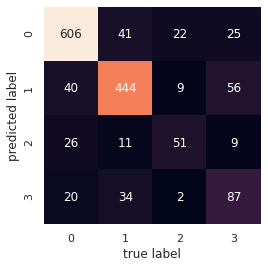

In [ ]:
mat = confusion_matrix(y_val, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1', '2', '3'], yticklabels=['0', '1', '2', '3'])
plt.xlabel('true label')
plt.ylabel('predicted label');

### Evaluation

#### k-fold Cross Validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

In [ ]:
# preparar el procedimiento de cross-validation 
cv = KFold(n_splits=5, random_state=1)
# crear el modelo
model = KNeighborsClassifier(n_neighbors=55, metric='manhattan',weights='uniform')
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.805 (0.017)


In [ ]:
# preparar el procedimiento de cross-validation 
cv = KFold(n_splits=5, random_state=1, shuffle=True)
# crear el modelo
model = KNeighborsClassifier(n_neighbors=55, metric='manhattan',weights='uniform')
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.803 (0.015)


#### Repeticiones de k-fold Cross Validation

In [ ]:
from sklearn.model_selection import RepeatedKFold

In [ ]:
# preparar el procedimiento de cross-validation 
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
# crear el modelo
model = KNeighborsClassifier(n_neighbors=55, metric='manhattan',weights='uniform')
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.803 (0.015)


#### Stratified k-fold Cross Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
# preparar el procedimiento de cross-validation 
cv = StratifiedKFold(n_splits=16,random_state=1, shuffle=False)
# crear el modelo
model = KNeighborsClassifier(n_neighbors=55, metric='manhattan',weights='uniform')
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.805 (0.031)


#### Shuffle Split

In [ ]:
from sklearn.model_selection import ShuffleSplit

In [ ]:
# preparar el procedimiento de cross-validation 
cv = ShuffleSplit(n_splits=16,train_size=0.8,random_state=1)
# crear el modelo
model = KNeighborsClassifier(n_neighbors=55, metric='manhattan',weights='uniform')
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.805 (0.018)


### Summary

The best hyperparameters for the model:

```
> metric: manhattan
> n_neighbors: 55
> weights: uniform
```

The best evaluation:

```
Shuffle Split: 
  > n_splits = 16
  > train_size=0.8
```
### We obtain an accuracy of: 80.5%


## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

### Searching for the best hyperparameters: 


#### **GRIDSEARCH:**

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth':[i for i in range (1,15)]
    }  

grid_search_dtree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=3, scoring='accuracy',
                           refit= True, verbose=2, n_jobs=-1)
grid_search_dtree.fit(X_train, y_train)

Fitting 3 folds for each of 56 candidates, totalling 168 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


CPU times: user 245 ms, sys: 15.1 ms, total: 260 ms
Wall time: 1.69 s


[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    1.7s finished


In [ ]:
grid_search_dtree.best_params_

{'criterion': 'entropy', 'max_depth': 6, 'splitter': 'random'}

In [ ]:
grid_search_dtree.best_score_

0.927800269905533

In [ ]:
dtree=grid_search_dtree.best_estimator_

In [ ]:
print(f'> Conjunto de validación: {dtree.score(X_val,y_val)}')

> Conjunto de validación: 0.7943358057990559


#### **RANDOM SEARCH**

In [ ]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth':randint(low=1, high=301)
    }


rnd_search_dtree = RandomizedSearchCV(DecisionTreeClassifier(), param_distribs,
                                n_iter=10, cv=3, scoring='accuracy', random_state=42, verbose=2, n_jobs=-1)

rnd_search_dtree.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


CPU times: user 127 ms, sys: 5.25 ms, total: 132 ms
Wall time: 635 ms


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.6s finished


In [ ]:
rnd_search_dtree.best_params_

{'criterion': 'entropy', 'max_depth': 49, 'splitter': 'best'}

In [ ]:
rnd_search_dtree.best_score_

0.910425101214575

In [ ]:
dtree=rnd_search_dtree.best_estimator_

In [ ]:
print(f'> Conjunto de validación: {dtree.score(X_val,y_val)}')

> Conjunto de validación: 0.8105192178017532


#### **Optimización Bayesiana:**

In [ ]:
%%capture
! pip install scikit-optimize

In [ ]:
from skopt import BayesSearchCV

In [ ]:
%%time

from skopt.space import Real, Categorical, Integer #Permite definir el tipo
param_distribs = {  #permite indicar la distribución de los parámetros
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth':Real(1, 301, 'uniform')
    }


bayes_search_dtree = BayesSearchCV(
    DecisionTreeClassifier(),
    param_distribs,
    n_iter=10,
    cv=3, scoring='accuracy', random_state=42,
    n_jobs=-1,
    optimizer_kwargs={'base_estimator': 'GP'} # 'GP': Gaussean Process,'RF': Random Forest regressor,'ET': Extra Trees regressor, 'GBRT': gradient boosted trees
  )
bayes_search_dtree.fit(X_train, y_train)

print(bayes_search_dtree.best_params_)

OrderedDict([('criterion', 'entropy'), ('max_depth', 276.6167565008131), ('splitter', 'best')])
CPU times: user 931 ms, sys: 466 ms, total: 1.4 s
Wall time: 1.24 s


In [ ]:
bayes_search_dtree.best_params_

OrderedDict([('criterion', 'entropy'),
             ('max_depth', 276.6167565008131),
             ('splitter', 'best')])

In [ ]:
bayes_search_dtree.best_score_

0.909919028340081

In [ ]:
dtree=bayes_search_dtree.best_estimator_

In [ ]:
print(f'> Conjunto de validación: {dtree.score(X_val,y_val)}')

> Conjunto de validación: 0.8105192178017532


#### **HYPERBAND:**

In [ ]:
%%capture
!git clone https://github.com/thuijskens/scikit-hyperband.git
%cd scikit-hyperband
!python setup.py install

In [ ]:
from hyperband import HyperbandSearchCV
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Distributions or lists of parameters to try. Distributions must provide a rvs method for sampling (such as those from scipy.stats.distributions). If a list is given, it is sampled uniformly.
param_grid = {  
     'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
      'max_depth':randint(low=1, high=301)
     }


In [ ]:
%%time
Hyb_search_dtree = HyperbandSearchCV(DecisionTreeClassifier(),
                           param_grid,
                           resource_param='max_depth', 
                           verbose =1,
                           max_iter=500, #Numero de árboles máximo en una iteración
                           min_iter=30, #Numero de árboles mínimo en una iteración
                           eta=3, #Reducción de recursos en cada iteración
                           cv=3,
                           scoring='accuracy',
                           random_state = 42)

Hyb_search_dtree.fit(X_train, y_train)

Starting bracket 1 (out of 3) of hyperband
Starting successive halving iteration 1 out of 3. Fitting 9 configurations, with resource_param max_depth set to 55, and keeping the best 3 configurations.
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting successive halving iteration 2 out of 3. Fitting 3 configurations, with resource_param max_depth set to 166, and keeping the best 1 configurations.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting successive halving iteration 3 out of 3. Fitting 1 configurations, with resource_param max_depth set to 500
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Starting bracket 2 (out of 3) of hyperband
Starting successive halving iteration 1 out of 2. Fitting 3 configurations, with resource_param max_depth set to 166, and keeping the best 1 configurations.
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Starting successive halving iteration 2 out of 2. Fitting 1 configurations, with resource_param max_depth set to 500
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Starting bracket 3 (out of 3) of hyperband
Starting successive halving iteration 1 out of 1. Fitting 3 configurations, with resource_param max_depth set to 500, and keeping the best 1 configurations.
Fitting 3 folds for each of 3 candidates, totalling 9 fits
CPU times: user 1.26 s, sys: 2.62 ms, total: 1.26 s
Wall time: 1.26 s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished


In [ ]:
Hyb_search_dtree.best_params_

{'criterion': 'entropy', 'max_depth': 55, 'splitter': 'best'}

In [ ]:
Hyb_search_dtree.best_score_

0.9109311740890689

In [ ]:
dtree=Hyb_search_dtree.best_estimator_

In [ ]:
print(f'> Conjunto de validación: {dtree.score(X_val,y_val)}')

> Conjunto de validación: 0.8078219824679703


### The best hyperparameters for the model: 

```
> criterion: entropy
> splitter: best
> max_depth: 49
```



#### Confusion matrix an other metrics: 

In [ ]:
DT = DecisionTreeClassifier(criterion= 'entropy', max_depth= 49, splitter= 'best',random_state=45)
DT.fit(X_train, y_train)
y_pred = DT.predict(X_val)
print('Accuracy: ' + str(DT.score(X_val, y_val)))
print('')
print(classification_report(y_val,y_pred))

Accuracy: 0.811193526635199

              precision    recall  f1-score   support

           0       0.89      0.88      0.89       692
           1       0.81      0.86      0.83       530
           2       0.55      0.70      0.61        84
           3       0.62      0.44      0.51       177

    accuracy                           0.81      1483
   macro avg       0.72      0.72      0.71      1483
weighted avg       0.81      0.81      0.81      1483



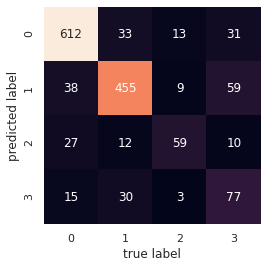

In [ ]:
mat = confusion_matrix(y_val, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1', '2', '3'], yticklabels=['0', '1', '2', '3'])
plt.xlabel('true label')
plt.ylabel('predicted label');

### Evaluation

#### k-fold Cross Validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

In [ ]:
# preparar el procedimiento de cross-validation 
cv = KFold(n_splits=5)
# crear el modelo
model = DecisionTreeClassifier(criterion= 'entropy', max_depth= 49, splitter= 'best')
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.728 (0.023)


In [ ]:
# preparar el procedimiento de cross-validation 
cv = KFold(n_splits=5, random_state=1, shuffle=True)
# crear el modelo
model = DecisionTreeClassifier(criterion= 'entropy', max_depth= 49, splitter= 'best')
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.728 (0.015)


#### Repeticiones de k-fold Cross Validation

In [ ]:
from sklearn.model_selection import RepeatedKFold

In [ ]:
# preparar el procedimiento de cross-validation 
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
# crear el modelo
model = DecisionTreeClassifier(criterion= 'entropy', max_depth= 49, splitter= 'best')
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.735 (0.013)


#### Stratified k-fold Cross Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
# preparar el procedimiento de cross-validation 
cv = StratifiedKFold(n_splits=16,random_state=1, shuffle=False)
# crear el modelo
model = DecisionTreeClassifier(criterion= 'entropy', max_depth= 49, splitter= 'best')
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.730 (0.041)


#### Shuffle Split

In [ ]:
from sklearn.model_selection import ShuffleSplit

In [ ]:
# preparar el procedimiento de cross-validation 
cv = ShuffleSplit(n_splits=16,train_size=0.8,random_state=1)
# crear el modelo
model = DecisionTreeClassifier(criterion= 'entropy', max_depth= 49, splitter= 'best')
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.717 (0.021)


### Summary
The best hyperparameters for the model:

```
> criterion: entropy
> splitter: best
> max_depth: 49
```

The best evaluation:

```
  > n_splits = 5
  > n_repeats=1
```
### We obtain an accuracy of: 73.5%


## SVM

In [ ]:
from sklearn.svm import SVC

### Searching for the best hyperparameters:

#### **Algorithms based on nature**

In [ ]:
%%capture
#! instalamos la librería sklearn_nature_inspired_algorithms
! pip install sklearn_nature_inspired_algorithms==0.4.3

In [ ]:
from sklearn_nature_inspired_algorithms.model_selection.nature_inspired_search_cv import NatureInspiredSearchCV
from sklearn_nature_inspired_algorithms.helpers import score_by_generation_lineplot

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from scipy.stats import loguniform,expon
param_grid = {
    'kernel':['linear'],
     'C': [0.5 +i/2 for i in range (1,20,1)], 
     'gamma': [0.01, 0.1,0.5, 1.0],
     'degree':[i for i in range (1,10)]
    }   


In [ ]:
%%time

nia_search_svm = NatureInspiredSearchCV(
    SVC(),
    param_grid,
    cv=3,
    verbose=1,
    algorithm='ba', #Bat Algorithm
    population_size=5,
    max_stagnating_gen=5, 
    n_jobs=-1,
    scoring="accuracy",
    random_state=42)

nia_search_svm.fit(X_train, y_train)
print(nia_search_svm)

Fitting 3 folds for some of the 684 candidates, which might total in 2052 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


NatureInspiredSearchCV(algorithm=None, cv=3, error_score=nan,
                       estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                     class_weight=None, coef0=0.0,
                                     decision_function_shape='ovr', degree=3,
                                     gamma='scale', kernel='rbf', max_iter=-1,
                                     probability=False, random_state=None,
                                     shrinking=True, tol=0.001, verbose=False),
                       iid='deprecated', max_n_gen=None,
                       max_stagnating_gen=None, n_jobs=-1, param_grid=None,
                       population_size=None, pre_dispatch='2*n_jobs',
                       random_state=None, refit=True, return_train_score=True,
                       runs=None, scoring='accuracy', verbose=1)
CPU times: user 1.07 s, sys: 85.1 ms, total: 1.16 s
Wall time: 19.3 s


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [ ]:
nia_search_svm.best_params_

{'C': 10.0, 'degree': 6, 'gamma': 0.5, 'kernel': 'linear'}

In [ ]:
nia_search_svm.best_score_

0.9326923076923078

In [ ]:
svm=nia_search_svm.best_estimator_

In [ ]:
print(f'> Conjunto de validación: {svm.score(X_val,y_val)}')

> Conjunto de validación: 0.8024275118004046


#### **RANDOM SEARCH**

In [ ]:
%%time

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform,expon

param_distribs = {
    'kernel':['poly'],
     'degree':loguniform(1, 10)
    }  

rnd_search_svc = RandomizedSearchCV(SVC(), param_distribs,
                                n_iter=10, cv=3, scoring='accuracy', random_state=42, verbose=2, n_jobs=-1)

rnd_search_svc.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


CPU times: user 254 ms, sys: 29.8 ms, total: 284 ms
Wall time: 3.44 s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.3s finished


In [ ]:
rnd_search_svc.best_params_

{'degree': 1.432249371823025, 'kernel': 'poly'}

In [ ]:
rnd_search_svc.best_score_

0.9323549257759783

In [ ]:
svc=rnd_search_svc.best_estimator_

In [ ]:
print(f'> Conjunto de validación: {svc.score(X_val,y_val)}')

> Conjunto de validación: 0.803776129467296


#### **HYPERBAND:**

In [ ]:
%%capture
!git clone https://github.com/thuijskens/scikit-hyperband.git
%cd scikit-hyperband
!python setup.py install

In [ ]:
from hyperband import HyperbandSearchCV
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Distributions or lists of parameters to try. Distributions must provide a rvs method for sampling (such as those from scipy.stats.distributions). If a list is given, it is sampled uniformly.
param_grid = {
    'kernel':['rbf'],
     'C': loguniform(1, 20), 
     'gamma': expon(scale=1.0)
    }  

In [ ]:
%%time
Hyb_search_svc = HyperbandSearchCV(SVC(),
                           param_grid,
                           resource_param='C', #Recursos que se asignarán en cada estimacion. En Random Forest tipicamente el número de árboles
                           verbose =1,
                           max_iter=500, #Numero de árboles máximo en una iteración
                           min_iter=30, #Numero de árboles mínimo en una iteración
                           eta=3, #Reducción de recursos en cada iteración
                           cv=3,
                           scoring='accuracy',
                           random_state = 42)

Hyb_search_svc.fit(X_train, y_train)

Starting bracket 1 (out of 3) of hyperband
Starting successive halving iteration 1 out of 3. Fitting 9 configurations, with resource_param C set to 55, and keeping the best 3 configurations.
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    9.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting successive halving iteration 2 out of 3. Fitting 3 configurations, with resource_param C set to 166, and keeping the best 1 configurations.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting successive halving iteration 3 out of 3. Fitting 1 configurations, with resource_param C set to 500
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting bracket 2 (out of 3) of hyperband
Starting successive halving iteration 1 out of 2. Fitting 3 configurations, with resource_param C set to 166, and keeping the best 1 configurations.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting successive halving iteration 2 out of 2. Fitting 1 configurations, with resource_param C set to 500
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting bracket 3 (out of 3) of hyperband
Starting successive halving iteration 1 out of 1. Fitting 3 configurations, with resource_param C set to 500, and keeping the best 1 configurations.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.8s finished


CPU times: user 25.9 s, sys: 36.8 ms, total: 25.9 s
Wall time: 26 s


In [ ]:
Hyb_search_svc.best_params_

{'C': 500, 'gamma': 0.047563849756408545, 'kernel': 'rbf'}

In [ ]:
Hyb_search_svc.best_score_

0.9315114709851552

In [ ]:
svc=Hyb_search_svc.best_estimator_

In [ ]:
print(f'> Conjunto de validación: {svc.score(X_val,y_val)}')

> Conjunto de validación: 0.7997302764666218


#### **Optimización Bayesiana:**

In [ ]:
%%capture
! pip install scikit-optimize

In [ ]:
from skopt import BayesSearchCV

In [ ]:
%%time
from skopt.space import Real, Categorical, Integer
param_distribs = {
        'kernel':  Categorical(['linear']),
        'C': Real(1, 20, 'log-uniform'),
        'gamma': Real(1e-6, 5, 'log-uniform'), 
    }

bayes_search_svc = BayesSearchCV(
    SVC(),
    param_distribs,
    n_iter=10,
    cv=3, scoring='accuracy', random_state=42,
    n_jobs=-1,
    optimizer_kwargs={'base_estimator': 'GP'} # 'GP': Gaussean Process,'RF': Random Forest regressor,'ET': Extra Trees regressor, 'GBRT': gradient boosted trees
  )
bayes_search_svc.fit(X_train, y_train)


CPU times: user 1 s, sys: 513 ms, total: 1.52 s
Wall time: 5.54 s


In [ ]:
bayes_search_svc.best_params_

OrderedDict([('C', 3.4163121995091106),
             ('gamma', 0.07499165270761127),
             ('kernel', 'linear')])

In [ ]:
bayes_search_svc.best_score_

0.9326923076923077

In [ ]:
svc=bayes_search_svc.best_estimator_

In [ ]:
print(f'> Conjunto de validación: {svc.score(X_val,y_val)}')

> Conjunto de validación: 0.8017532029669588


### The best hyperparameters for the model: 

```
> kernel: linear
> gamma: 0.5
> C: 10
```



#### Confusion matrix an other metrics: 

In [ ]:
svc = SVC(kernel= 'linear', gamma=0.5,C=10)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_val)
print('Accuracy: ' + str(svc.score(X_val, y_val)))
print('')
print(classification_report(y_val,y_pred))

Accuracy: 0.8024275118004046

              precision    recall  f1-score   support

           0       0.88      0.87      0.88       692
           1       0.80      0.85      0.83       530
           2       0.53      0.65      0.59        84
           3       0.61      0.46      0.52       177

    accuracy                           0.80      1483
   macro avg       0.71      0.71      0.70      1483
weighted avg       0.80      0.80      0.80      1483



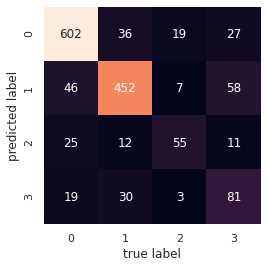

In [ ]:
mat = confusion_matrix(y_val, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1', '2', '3'], yticklabels=['0', '1', '2', '3'])
plt.xlabel('true label')
plt.ylabel('predicted label');

### Evaluation

#### k-fold Cross Validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

In [ ]:
# preparar el procedimiento de cross-validation 
cv = KFold(n_splits=5, random_state=1)
# crear el modelo
model = SVC(kernel= 'linear', gamma=0.5,C=10)
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.806 (0.022)


In [ ]:
# preparar el procedimiento de cross-validation 
cv = KFold(n_splits=5, random_state=1, shuffle=True)
# crear el modelo
model = SVC(kernel= 'linear', gamma=0.5,C=10)
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.804 (0.015)


#### Repeticiones de k-fold Cross Validation

In [ ]:
from sklearn.model_selection import RepeatedKFold

In [ ]:
# preparar el procedimiento de cross-validation 
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
# crear el modelo
model = SVC(kernel= 'linear', gamma=0.5,C=10)
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.804 (0.015)


#### Stratified k-fold Cross Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
# preparar el procedimiento de cross-validation 
cv = StratifiedKFold(n_splits=16,random_state=1, shuffle=False)
# crear el modelo
model = SVC(kernel= 'linear', gamma=0.5,C=10)
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.806 (0.031)


#### Shuffle Split

In [ ]:
from sklearn.model_selection import ShuffleSplit

In [ ]:
# preparar el procedimiento de cross-validation 
cv = ShuffleSplit(n_splits=2,train_size=0.8,random_state=1)
# crear el modelo
model = SVC(kernel= 'linear', gamma=0.5,C=10)
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.808 (0.000)


### Summary

The best hyperparameters for the model:

```
> kernel: linear
> gamma: 0.5
> C: 10
```

The best evaluation:

```
Shuffle Split: 
  > n_splits = 16
  > train_size=0.8
```
### We obtain an accuracy of: 80.8%


##Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

### Searching for the best hyperparameters:

#### **GRIDSEARCH:**

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

grid_search_NB= GridSearchCV(GaussianNB(), param_grid, cv=3, scoring='accuracy',
                           refit= True, verbose=2, n_jobs=-1)
grid_search_NB.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:    2.5s


CPU times: user 473 ms, sys: 46.1 ms, total: 520 ms
Wall time: 2.77 s


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.7s finished


In [ ]:
grid_search_NB.best_params_

{'var_smoothing': 0.1}

In [ ]:
grid_search_NB.best_score_

0.9326923076923076

In [ ]:
NB=grid_search_NB.best_estimator_

In [ ]:
print(f'> Conjunto de validación: {NB.score(X_val,y_val)}')

> Conjunto de validación: 0.8010788941335132


### Confusion matrics and other metrics: 

In [ ]:
GNB = GaussianNB(var_smoothing= 0.1)
GNB.fit(X_train, y_train)
y_pred = GNB.predict(X_val)
print('Accuracy: ' + str(GNB.score(X_val, y_val)))
print('')
print(classification_report(y_val,y_pred))

Accuracy: 0.8010788941335132

              precision    recall  f1-score   support

           0       0.88      0.87      0.87       692
           1       0.79      0.86      0.83       530
           2       0.51      0.62      0.56        84
           3       0.63      0.45      0.53       177

    accuracy                           0.80      1483
   macro avg       0.71      0.70      0.70      1483
weighted avg       0.80      0.80      0.80      1483



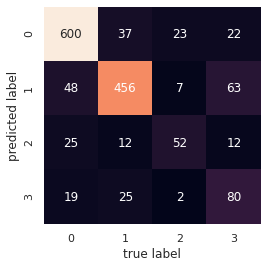

In [ ]:
mat = confusion_matrix(y_val, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1', '2', '3'], yticklabels=['0', '1', '2', '3'])
plt.xlabel('true label')
plt.ylabel('predicted label');

### Evaluation

####k-fold Cross Validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

In [ ]:
# preparar el procedimiento de cross-validation 
cv = KFold(n_splits=5, random_state=1)
# crear el modelo
model = GaussianNB(var_smoothing= 0.1)
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.802 (0.018)


In [ ]:
# preparar el procedimiento de cross-validation 
cv = KFold(n_splits=5, random_state=1, shuffle=True)
# crear el modelo
model = GaussianNB(var_smoothing= 0.1)
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.805 (0.016)


#### Repeticiones de k-fold Cross Validation

In [ ]:
from sklearn.model_selection import RepeatedKFold

In [ ]:
# preparar el procedimiento de cross-validation 
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
# crear el modelo
model = GaussianNB(var_smoothing= 0.1)
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.805 (0.016)


#### Stratified k-fold Cross Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
# preparar el procedimiento de cross-validation 
cv = StratifiedKFold(n_splits=16,random_state=1, shuffle=False)
# crear el modelo
model = GaussianNB(var_smoothing= 0.1)
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.803 (0.033)


#### Shuffle Split

In [ ]:
from sklearn.model_selection import ShuffleSplit

In [ ]:
# preparar el procedimiento de cross-validation 
cv = ShuffleSplit(n_splits=1,train_size=0.8,random_state=1)
# crear el modelo
model = GaussianNB(var_smoothing= 0.1)
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.811 (0.000)


In [ ]:
# preparar el procedimiento de cross-validation 
cv = ShuffleSplit(n_splits=37,train_size=0.8,random_state=1)
# crear el modelo
model = GaussianNB(var_smoothing= 0.1)
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.806 (0.021)


### Summary

The best hyperparameters for the model:

```
> var_smoothing= 0.1
```

### And the best evaluation:

```
Shuffle Split: 
  > n_splits = 1
  > train_size=0.8
```
### We obtain an accuracy of: 81.1%


## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

### Searching for the best hyperparameters: 


#### **GRIDSEARCH:**

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10,50,100,150,200],
    'criterion': ['gini', 'entropy'],
    'max_depth':[5,10,None],
    'max_features' : [5,10,'auto']
    }  

grid_search_RF = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='accuracy',
                           refit= True, verbose=2, n_jobs=-1)
grid_search_RF.fit(X_train, y_train)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 214 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  1.1min finished


CPU times: user 2.58 s, sys: 107 ms, total: 2.69 s
Wall time: 1min 6s


In [ ]:
grid_search_RF.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'n_estimators': 200}

In [ ]:
grid_search_RF.best_score_

0.9310053981106613

In [ ]:
RF=grid_search_RF.best_estimator_

In [ ]:
print(f'> Conjunto de validación: {RF.score(X_val,y_val)}')

> Conjunto de validación: 0.799055967633176


#### **RANDOM SEARCH**

In [ ]:
%%time

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'n_estimators': [10,25,50,75,100,125,150,175,200],
    'criterion': ['gini', 'entropy'],
    'max_depth':[5,10,15,None],
    'max_features' : [5,10,15,'auto']
    }  


rnd_search_RF = RandomizedSearchCV(RandomForestClassifier(), param_distribs,
                                n_iter=10, cv=3, scoring='accuracy', random_state=42, verbose=2, n_jobs=-1)

rnd_search_RF.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.5s finished


CPU times: user 387 ms, sys: 10 ms, total: 397 ms
Wall time: 1.77 s


In [ ]:
rnd_search_RF.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'auto',
 'n_estimators': 25}

In [ ]:
rnd_search_RF.best_score_

0.9304993252361674

In [ ]:
RF=rnd_search_RF.best_estimator_

In [ ]:
print(f'> Conjunto de validación: {RF.score(X_val,y_val)}')

> Conjunto de validación: 0.8017532029669588


#### **Optimización Bayesiana:**

In [ ]:
%%capture
! pip install scikit-optimize

In [ ]:
from skopt import BayesSearchCV

In [ ]:
%%time

from skopt.space import Real, Categorical, Integer #Permite definir el tipo

param_distribs = {
    'n_estimators': Integer(1, 300, 'log_uniform'),
    'criterion': ['gini', 'entropy'],
    'max_depth':[5,10,15,20]
    } 

bayes_search_RF = BayesSearchCV(
    RandomForestClassifier(),
    param_distribs,
    n_iter=10,
    cv=3, scoring='accuracy', random_state=42,
    n_jobs=-1,
    optimizer_kwargs={'base_estimator': 'GP'} # 'GP': Gaussean Process,'RF': Random Forest regressor,'ET': Extra Trees regressor, 'GBRT': gradient boosted trees
  )
bayes_search_RF.fit(X_train, y_train)

print(bayes_search_RF.best_params_)

OrderedDict([('criterion', 'gini'), ('max_depth', 10), ('n_estimators', 180)])
CPU times: user 2.59 s, sys: 539 ms, total: 3.13 s
Wall time: 35.3 s


In [ ]:
bayes_search_RF.best_params_

OrderedDict([('criterion', 'gini'), ('max_depth', 10), ('n_estimators', 180)])

In [ ]:
bayes_search_RF.best_score_

0.9230769230769231

In [ ]:
RF=bayes_search_RF.best_estimator_

In [ ]:
print(f'> Conjunto de validación: {RF.score(X_val,y_val)}')

> Conjunto de validación: 0.7977073499662846


#### **HYPERBAND:**

In [ ]:
%%capture
!git clone https://github.com/thuijskens/scikit-hyperband.git
%cd scikit-hyperband
!python setup.py install

In [ ]:
from hyperband import HyperbandSearchCV
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Distributions or lists of parameters to try. Distributions must provide a rvs method for sampling (such as those from scipy.stats.distributions). If a list is given, it is sampled uniformly.
param_grid = {
    'n_estimators': [10,25,50,75,100,125,150,175,200],
    'criterion': ['gini', 'entropy'],
    'max_depth':[5,10,15,None]
    }  


In [ ]:
%%time

Hyb_search_RF = HyperbandSearchCV(RandomForestClassifier(),
                           param_grid,
                           resource_param='n_estimators', #Recursos que se asignarán en cada estimacion. En Random Forest tipicamente el número de árboles
                           verbose =1,
                           max_iter=500, #Numero de árboles máximo en una iteración
                           min_iter=30, #Numero de árboles mínimo en una iteración
                           eta=3, #Reducción de recursos en cada iteración
                           cv=3,
                           scoring='accuracy',
                           random_state = 42)

Hyb_search_RF.fit(X_train, y_train)

Starting bracket 1 (out of 3) of hyperband
Starting successive halving iteration 1 out of 3. Fitting 9 configurations, with resource_param n_estimators set to 55, and keeping the best 3 configurations.
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   10.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting successive halving iteration 2 out of 3. Fitting 3 configurations, with resource_param n_estimators set to 166, and keeping the best 1 configurations.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   10.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting successive halving iteration 3 out of 3. Fitting 1 configurations, with resource_param n_estimators set to 500
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting bracket 2 (out of 3) of hyperband
Starting successive halving iteration 1 out of 2. Fitting 3 configurations, with resource_param n_estimators set to 166, and keeping the best 1 configurations.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   10.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting successive halving iteration 2 out of 2. Fitting 1 configurations, with resource_param n_estimators set to 500
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting bracket 3 (out of 3) of hyperband
Starting successive halving iteration 1 out of 1. Fitting 3 configurations, with resource_param n_estimators set to 500, and keeping the best 1 configurations.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   36.8s finished


CPU times: user 1min 22s, sys: 142 ms, total: 1min 22s
Wall time: 1min 22s


In [ ]:
Hyb_search_RF.best_params_

{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 166}

In [ ]:
Hyb_search_RF.best_score_

0.9313427800269906

In [ ]:
RF=Hyb_search_RF.best_estimator_

In [ ]:
print(f'> Conjunto de validación: {RF.score(X_val,y_val)}')

> Conjunto de validación: 0.799055967633176


### The best hyperparameters for the model: 



```
> criterion: entropy
> max_depth: 5
> max_features: 'auto'
> n_estimators: 25
```

#### Confusion matrics and other metrics: 

In [ ]:
RF = RandomForestClassifier(criterion='entropy',max_depth=5,max_features='auto',n_estimators=25)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_val)
print('Accuracy: ' + str(RF.score(X_val, y_val)))
print('')
print(classification_report(y_val,y_pred))

Accuracy: 0.7977073499662846

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       692
           1       0.80      0.85      0.83       530
           2       0.52      0.64      0.57        84
           3       0.56      0.45      0.50       177

    accuracy                           0.80      1483
   macro avg       0.69      0.70      0.69      1483
weighted avg       0.80      0.80      0.80      1483



Empeoramos un poco los resultados en la clase 2

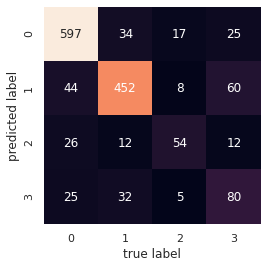

In [ ]:
mat = confusion_matrix(y_val, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1', '2', '3'], yticklabels=['0', '1', '2', '3'])
plt.xlabel('true label')
plt.ylabel('predicted label');

### Evaluation

#### k-fold Cross Validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

In [ ]:
# preparar el procedimiento de cross-validation 
cv = KFold(n_splits=5, random_state=1)
# crear el modelo
model = RandomForestClassifier(criterion='entropy',max_depth=5,max_features='auto',n_estimators=25)
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.806 (0.020)


In [ ]:
# preparar el procedimiento de cross-validation 
cv = KFold(n_splits=5, random_state=1, shuffle=True)
# crear el modelo
model = RandomForestClassifier(criterion='entropy',max_depth=5,max_features='auto',n_estimators=25)
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.798 (0.014)


#### Repeticiones de k-fold Cross Validation

In [ ]:
from sklearn.model_selection import RepeatedKFold

In [ ]:
# preparar el procedimiento de cross-validation 
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
# crear el modelo
model = RandomForestClassifier(criterion='entropy',max_depth=5,max_features='auto',n_estimators=25)
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.799 (0.018)


#### Stratified k-fold Cross Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
# preparar el procedimiento de cross-validation 
cv = StratifiedKFold(n_splits=16,random_state=1, shuffle=False)
# crear el modelo
model = RandomForestClassifier(criterion='entropy',max_depth=5,max_features='auto',n_estimators=25)
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.806 (0.036)


#### Shuffle Split

In [ ]:
from sklearn.model_selection import ShuffleSplit

In [ ]:
# preparar el procedimiento de cross-validation 
cv = ShuffleSplit(n_splits=16,train_size=0.8,random_state=1)
# crear el modelo
model = RandomForestClassifier(criterion='entropy',max_depth=5,max_features='auto',n_estimators=25)
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.802 (0.017)


### Summary
The best hyperparameters for the model:

```
> criterion: entropy
> max_depth: 5
> max_features: 'auto'
> n_estimators: 25
```

### And the best evaluation:

```
KFold:
  > n_splits=5
```
### We obtain an accuracy of: 80.6%


## Neural Networks

In [ ]:
from sklearn.neural_network import MLPClassifier

### Searching for the best hyperparameters: 


#### **GRIDSEARCH:**

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(100,),(125,),(150,),(100,50,),(150,75,),(150,100,50)],
    'activation': ['relu','logistic'],
    'solver':['sgd','adam'],
    'alpha' : [0.0001,0.001,0.05,0.01,0.1,0.5],
    'momentum' : [0.85,0.9,0.95,0.99],
    'max_iter': [200,500,1000]
    }  

grid_search_MLP = GridSearchCV(MLPClassifier(), param_grid, cv=3, scoring='accuracy',
                           refit= True, verbose=2, n_jobs=-1)
grid_search_MLP.fit(X_train, y_train)

Fitting 3 folds for each of 1728 candidates, totalling 5184 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 33.8min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 44.5min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 62.4min
[Parallel(n_jobs=-1)]: Done 3277 tasks      | elapsed: 81.3min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 105.2min
[Parallel(n_jobs=-1)]: Done 4897 tasks      | elapsed: 131.0min
[Parallel(n_jobs=-1)]: Done 5184 out of 5184 | elapsed: 141.2min finished


CPU times: user 57.6 s, sys: 17.3 s, total: 1min 14s
Wall time: 2h 21min 30s


In [ ]:
grid_search_MLP.best_params_

{'activation': 'logistic',
 'alpha': 0.05,
 'hidden_layer_sizes': (150, 100, 50),
 'max_iter': 1000,
 'momentum': 0.95,
 'solver': 'adam'}

In [ ]:
grid_search_MLP.best_score_

0.9342105263157895

In [ ]:
MLP=grid_search_MLP.best_estimator_

In [ ]:
print(f'> Conjunto de validación: {MLP.score(X_val,y_val)}')

> Conjunto de validación: 0.7997302764666218


#### **RANDOM SEARCH**

In [ ]:
%%time

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'hidden_layer_sizes': [(100,),(125,),(150,),(100,50,),(150,75,),(150,100,50)],
    'activation': ['relu','logistic'],
    'solver':['sgd','adam'],
    'alpha' : [0.001,0.05,0.01,0.1],
    'momentum' : [0.95,0.99],
    'max_iter': [1000]
    }  


rnd_search_MLP = RandomizedSearchCV(MLPClassifier(), param_distribs,
                                n_iter=10, cv=3, scoring='accuracy', random_state=42, verbose=2, n_jobs=-1)

rnd_search_MLP.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.3min finished


CPU times: user 3.63 s, sys: 11.7 ms, total: 3.64 s
Wall time: 1min 18s


In [ ]:
rnd_search_MLP.best_params_

{'activation': 'relu',
 'alpha': 0.001,
 'hidden_layer_sizes': (150,),
 'max_iter': 1000,
 'momentum': 0.95,
 'solver': 'adam'}

In [ ]:
rnd_search_MLP.best_score_

0.9330296896086371

In [ ]:
MLP=rnd_search_MLP.best_estimator_

In [ ]:
print(f'> Conjunto de validación: {MLP.score(X_val,y_val)}')

> Conjunto de validación: 0.8010788941335132


#### **Optimización Bayesiana:**

In [ ]:
%%capture
! pip install scikit-optimize

In [ ]:
from skopt import BayesSearchCV

In [ ]:
%%time

from skopt.space import Real, Categorical, Integer #Permite definir el tipo

param_distribs = {'activation': ['relu','logistic'],
    'solver':['adam'],
    'alpha' : [0.001,0.05,0.01,0.1],
    'momentum' : [0.95,0.99],
    'max_iter': [1000]
    } 

bayes_search_MLP = BayesSearchCV(
    MLPClassifier(),
    param_distribs,
    n_iter=10,
    cv=3, scoring='accuracy', random_state=42,
    n_jobs=-1,
    optimizer_kwargs={'base_estimator': 'GP'} # 'GP': Gaussean Process,'RF': Random Forest regressor,'ET': Extra Trees regressor, 'GBRT': gradient boosted trees
  )
bayes_search_MLP.fit(X_train, y_train)

print(bayes_search_MLP.best_params_)

OrderedDict([('activation', 'relu'), ('alpha', 0.1), ('max_iter', 1000), ('momentum', 0.983506257482421), ('solver', 'adam')])
CPU times: user 3.18 s, sys: 540 ms, total: 3.72 s
Wall time: 54.2 s


In [ ]:
bayes_search_MLP.best_params_

OrderedDict([('activation', 'relu'),
             ('alpha', 0.1),
             ('max_iter', 1000),
             ('momentum', 0.983506257482421),
             ('solver', 'adam')])

In [ ]:
bayes_search_MLP.best_score_

0.9337044534412956

In [ ]:
MLP=bayes_search_MLP.best_estimator_

In [ ]:
print(f'> Conjunto de validación: {MLP.score(X_val,y_val)}')

> Conjunto de validación: 0.8031018206338503


#### **HYPERBAND:**

In [ ]:
%%capture
!git clone https://github.com/thuijskens/scikit-hyperband.git
%cd scikit-hyperband
!python setup.py install

In [ ]:
from hyperband import HyperbandSearchCV
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Distributions or lists of parameters to try. Distributions must provide a rvs method for sampling (such as those from scipy.stats.distributions). If a list is given, it is sampled uniformly.
param_grid = {
    'hidden_layer_sizes': [(100,),(125,),(150,),(100,50,),(150,75,),(150,100,50)],
    'activation': ['relu','logistic'],
    'solver':['adam'],
    'alpha' : [0.001,0.05,0.01,0.1],
    'momentum' : [0.95,0.99],
    'max_iter': [1000]
    }  

In [ ]:
%%time

Hyb_search_MLP = HyperbandSearchCV(MLPClassifier(),
                           param_grid,
                           resource_param='alpha', #Recursos que se asignarán en cada estimacion. En Random Forest tipicamente el número de árboles
                           verbose =1,
                           max_iter=500, #Numero de árboles máximo en una iteración
                           min_iter=30, #Numero de árboles mínimo en una iteración
                           eta=3, #Reducción de recursos en cada iteración
                           cv=3,
                           scoring='accuracy',
                           random_state = 42)

Hyb_search_MLP.fit(X_train, y_train)

Starting bracket 1 (out of 3) of hyperband
Starting successive halving iteration 1 out of 3. Fitting 9 configurations, with resource_param alpha set to 55, and keeping the best 3 configurations.
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting successive halving iteration 2 out of 3. Fitting 3 configurations, with resource_param alpha set to 166, and keeping the best 1 configurations.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   31.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting successive halving iteration 3 out of 3. Fitting 1 configurations, with resource_param alpha set to 500
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting bracket 2 (out of 3) of hyperband
Starting successive halving iteration 1 out of 2. Fitting 3 configurations, with resource_param alpha set to 166, and keeping the best 1 configurations.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   40.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting successive halving iteration 2 out of 2. Fitting 1 configurations, with resource_param alpha set to 500
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting bracket 3 (out of 3) of hyperband
Starting successive halving iteration 1 out of 1. Fitting 3 configurations, with resource_param alpha set to 500, and keeping the best 1 configurations.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   40.9s finished


CPU times: user 5min 42s, sys: 2min 51s, total: 8min 34s
Wall time: 4min 50s


In [ ]:
Hyb_search_MLP.best_params_

{'activation': 'relu',
 'alpha': 55,
 'hidden_layer_sizes': (100,),
 'max_iter': 1000,
 'momentum': 0.95,
 'solver': 'adam'}

In [ ]:
Hyb_search_MLP.best_score_

0.8827597840755735

In [ ]:
MLP=Hyb_search_MLP.best_estimator_

In [ ]:
print(f'> Conjunto de validación: {MLP.score(X_val,y_val)}')

> Conjunto de validación: 0.7916385704652731


### The best hyperparameters for the model: 
```
> activation: 'relu'
> alpha: 0.1
> max_iter: 1000
> momentum: 0.983506257482421
> solver: 'adam'
```

#### Confusion matriz and other metrics: 

In [ ]:
MLP = MLPClassifier(activation='relu',alpha=0.1,max_iter=1000,momentum=0.983506257482421,solver='adam')
MLP.fit(X_train, y_train)
y_pred = MLP.predict(X_val)
print('Accuracy: ' + str(MLP.score(X_val, y_val)))
print('')
print(classification_report(y_val,y_pred))

Accuracy: 0.8024275118004046

              precision    recall  f1-score   support

           0       0.88      0.87      0.87       692
           1       0.82      0.84      0.83       530
           2       0.52      0.63      0.57        84
           3       0.59      0.51      0.55       177

    accuracy                           0.80      1483
   macro avg       0.70      0.71      0.71      1483
weighted avg       0.80      0.80      0.80      1483



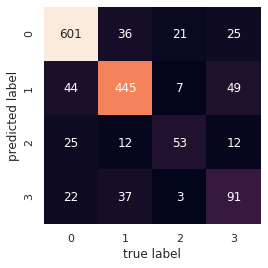

In [ ]:
mat = confusion_matrix(y_val, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1', '2', '3'], yticklabels=['0', '1', '2', '3'])
plt.xlabel('true label')
plt.ylabel('predicted label');

### Evaluation

####k-fold Cross Validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

In [ ]:
# preparar el procedimiento de cross-validation 
cv = KFold(n_splits=5, random_state=1)
# crear el modelo
### El mejor modelo lo obtenemos con los hiperparámetros: 
model = MLPClassifier(activation='relu',alpha=0.1,max_iter=1000,momentum=0.983506257482421,solver='adam')
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.800 (0.016)


In [ ]:
# preparar el procedimiento de cross-validation 
cv = KFold(n_splits=5, random_state=1, shuffle=True)
# crear el modelo
model = MLPClassifier(activation='relu',alpha=0.1,max_iter=1000,momentum=0.983506257482421,solver='adam')
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.803 (0.017)


#### Repeticiones de k-fold Cross Validation

In [ ]:
from sklearn.model_selection import RepeatedKFold

In [ ]:
# preparar el procedimiento de cross-validation 
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
# crear el modelo
model = MLPClassifier(activation='relu',alpha=0.1,max_iter=1000,momentum=0.983506257482421,solver='adam')
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.804 (0.018)


#### Stratified k-fold Cross Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
# preparar el procedimiento de cross-validation 
cv = StratifiedKFold(n_splits=16,random_state=1, shuffle=False)
# crear el modelo
model = MLPClassifier(activation='relu',alpha=0.1,max_iter=1000,momentum=0.983506257482421,solver='adam')
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.802 (0.036)


#### Shuffle Split

In [ ]:
from sklearn.model_selection import ShuffleSplit

In [ ]:
# preparar el procedimiento de cross-validation 
cv = ShuffleSplit(n_splits=16,train_size=0.8,random_state=1)
# crear el modelo
model = MLPClassifier(activation='relu',alpha=0.1,max_iter=1000,momentum=0.983506257482421,solver='adam')
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.797 (0.017)


### Summary
The best hyperparameters for the model:

```
> activation: 'relu'
> alpha: 0.1
> max_iter: 1000
> momentum: 0.983506257482421
> solver: 'adam'
```

### And the best evaluation:

```
RepeatedKFold:
  > n_splits=5
  > n_repeats=1
```
### We obtain an accuracy of: 80.4%


## Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

### Searching for the best hyperparameters: 


#### **GRIDSEARCH:**

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
    'penalty': ['l1','l2','elasticnet','none'],
    'C': [0.1,0.5,1,2],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }  

grid_search_LR = GridSearchCV(LogisticRegression(), param_grid, cv=3, scoring='accuracy',
                           refit= True, verbose=2, n_jobs=-1)
grid_search_LR.fit(X_train, y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    3.6s


CPU times: user 771 ms, sys: 60.2 ms, total: 831 ms
Wall time: 11.2 s


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   11.0s finished


In [ ]:
grid_search_LR.best_params_

{'C': 0.5, 'penalty': 'l2', 'solver': 'newton-cg'}

In [ ]:
grid_search_LR.best_score_

0.9330296896086369

In [ ]:
LR=grid_search_LR.best_estimator_

In [ ]:
print(f'> Conjunto de validación: {LR.score(X_val,y_val)}')

> Conjunto de validación: 0.8031018206338503


#### **RANDOM SEARCH**

In [ ]:
%%time

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'penalty': ['l1','l2','elasticnet','none'],
    'C': [0.1,0.5,1,2],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }  


rnd_search_LR = RandomizedSearchCV(LogisticRegression(), param_distribs,
                                n_iter=10, cv=3, scoring='accuracy', random_state=42, verbose=2, n_jobs=-1)

rnd_search_LR.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


CPU times: user 159 ms, sys: 3.69 ms, total: 162 ms
Wall time: 660 ms


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.6s finished


In [ ]:
rnd_search_LR.best_params_

{'C': 0.5, 'penalty': 'l2', 'solver': 'sag'}

In [ ]:
rnd_search_LR.best_score_

0.9330296896086369

In [ ]:
LR=rnd_search_LR.best_estimator_

In [ ]:
print(f'> Conjunto de validación: {LR.score(X_val,y_val)}')

> Conjunto de validación: 0.8031018206338503


#### **Optimización Bayesiana:**

In [ ]:
%%capture
! pip install scikit-optimize

In [ ]:
from skopt import BayesSearchCV

In [ ]:
%%time

from skopt.space import Real, Categorical, Integer #Permite definir el tipo
param_distribs = {
    'penalty': ['l1','l2'],
    'C': [0.1,0.5,1,2],
    'solver' : ['lbfgs', 'liblinear','saga']
    }  


bayes_search_LR = BayesSearchCV(
    LogisticRegression(),
    param_distribs,
    n_iter=10,
    cv=3, scoring='accuracy', random_state=42,
    n_jobs=-1,
    optimizer_kwargs={'base_estimator': 'GP'} # 'GP': Gaussean Process,'RF': Random Forest regressor,'ET': Extra Trees regressor, 'GBRT': gradient boosted trees
  )
bayes_search_LR.fit(X_train, y_train)

print(bayes_search_LR.best_params_)

OrderedDict([('C', 0.5), ('penalty', 'l2'), ('solver', 'saga')])
CPU times: user 1.04 s, sys: 517 ms, total: 1.55 s
Wall time: 3.77 s


In [ ]:
bayes_search_LR.best_params_

OrderedDict([('C', 0.5), ('penalty', 'l2'), ('solver', 'saga')])

In [ ]:
bayes_search_LR.best_score_

0.933029689608637

In [ ]:
LR=bayes_search_LR.best_estimator_

In [ ]:
print(f'> Conjunto de validación: {LR.score(X_val,y_val)}')

> Conjunto de validación: 0.8031018206338503


#### **HYPERBAND:**

In [ ]:
%%capture
!git clone https://github.com/thuijskens/scikit-hyperband.git
%cd scikit-hyperband
!python setup.py install

In [ ]:
from hyperband import HyperbandSearchCV
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Distributions or lists of parameters to try. Distributions must provide a rvs method for sampling (such as those from scipy.stats.distributions). If a list is given, it is sampled uniformly.
param_grid = {
    'C': [0.1,0.5,1,2],
    'solver' : ['lbfgs', 'liblinear','saga']
    }  


In [ ]:
%%time

Hyb_search_LR = HyperbandSearchCV(LogisticRegression(),
                           param_grid,
                           resource_param='C', #Recursos que se asignarán en cada estimacion. En Random Forest tipicamente el número de árboles
                           verbose =1,
                           max_iter=500, #Numero de árboles máximo en una iteración
                           min_iter=30, #Numero de árboles mínimo en una iteración
                           eta=3, #Reducción de recursos en cada iteración
                           cv=3,
                           scoring='accuracy',
                           random_state = 42)

Hyb_search_LR.fit(X_train, y_train)

Starting bracket 1 (out of 3) of hyperband
Starting successive halving iteration 1 out of 3. Fitting 9 configurations, with resource_param C set to 55, and keeping the best 3 configurations.
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting successive halving iteration 2 out of 3. Fitting 3 configurations, with resource_param C set to 166, and keeping the best 1 configurations.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting successive halving iteration 3 out of 3. Fitting 1 configurations, with resource_param C set to 500
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting bracket 2 (out of 3) of hyperband
Starting successive halving iteration 1 out of 2. Fitting 3 configurations, with resource_param C set to 166, and keeping the best 1 configurations.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting successive halving iteration 2 out of 2. Fitting 1 configurations, with resource_param C set to 500
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Starting bracket 3 (out of 3) of hyperband
Starting successive halving iteration 1 out of 1. Fitting 3 configurations, with resource_param C set to 500, and keeping the best 1 configurations.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s finished


CPU times: user 5.6 s, sys: 12.3 ms, total: 5.62 s
Wall time: 5.63 s


In [ ]:
Hyb_search_LR.best_params_

{'C': 55, 'solver': 'lbfgs'}

In [ ]:
Hyb_search_LR.best_score_

0.9328609986504723

In [ ]:
LR=Hyb_search_LR.best_estimator_

In [ ]:
print(f'> Conjunto de validación: {LR.score(X_val,y_val)}')

> Conjunto de validación: 0.8010788941335132


### The best hyperparameters for the model: 

```
> C: 0.5
> penalty: 'l2'
> solver: 'newton-cg'
```



### Confusion matriz and other metrics: 

In [ ]:
LR = LogisticRegression(C=0.5,penalty='l2',solver='newton-cg')
LR.fit(X_train, y_train)
y_pred = LR.predict(X_val)
print('Accuracy: ' + str(LR.score(X_val, y_val)))
print('')
print(classification_report(y_val,y_pred))

Accuracy: 0.8031018206338503

              precision    recall  f1-score   support

           0       0.88      0.87      0.87       692
           1       0.82      0.84      0.83       530
           2       0.53      0.64      0.58        84
           3       0.59      0.51      0.55       177

    accuracy                           0.80      1483
   macro avg       0.71      0.72      0.71      1483
weighted avg       0.80      0.80      0.80      1483



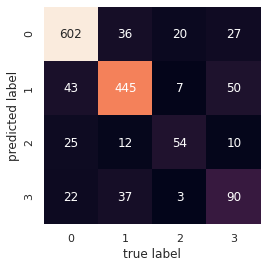

In [ ]:
mat = confusion_matrix(y_val, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1', '2', '3'], yticklabels=['0', '1', '2', '3'])
plt.xlabel('true label')
plt.ylabel('predicted label');

### Evaluation

####k-fold Cross Validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

In [ ]:
# preparar el procedimiento de cross-validation 
cv = KFold(n_splits=5, random_state=1)
# crear el modelo
model = LogisticRegression(C=0.5,penalty='l2',solver='newton-cg')
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.804 (0.020)


#### Repeticiones de k-fold Cross Validation

In [ ]:
from sklearn.model_selection import RepeatedKFold

In [ ]:
# preparar el procedimiento de cross-validation 
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
# crear el modelo
model = LogisticRegression(C=0.5,penalty='l2',solver='newton-cg')
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.801 (0.018)


#### Stratified k-fold Cross Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
# preparar el procedimiento de cross-validation 
cv = StratifiedKFold(n_splits=16,random_state=1, shuffle=False)
# crear el modelo
model = LogisticRegression(C=0.5,penalty='l2',solver='newton-cg')
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.805 (0.038)


#### Shuffle Split

In [ ]:
from sklearn.model_selection import ShuffleSplit

In [ ]:
# preparar el procedimiento de cross-validation 
cv = ShuffleSplit(n_splits=16,train_size=0.8,random_state=1)
# crear el modelo
model = LogisticRegression(C=0.5,penalty='l2',solver='newton-cg')
model.fit(X_train, y_train)
# evaluar el modelo
scores = cross_val_score(model, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
# mostrar el resultado
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.804 (0.016)


### Summary

The best hyperparameters for the model:

```
> C: 0.5
> penalty: 'l2'
> solver: 'newton-cg'
```

### And the best evaluation:

```
StratifiedKFold:
  > n_splits = 16
  > shuffle=False
```
### We obtain an accuracy of: 80.5%


# Evaluation in the test set

Once we have found the best hyperparameters for our machine learning algorithms we are going to evaluate all of them in out test set.

## kNN (K-Nearest Neighbors)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=55, metric='manhattan',weights='uniform')
knn.fit(X, y)
y_pred = knn.predict(X_test)

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
acc = accuracy_score(y_test, y_pred)

In [ ]:
print('Accuracy: '+str(acc))
print('Precision: '+str(precision))
print('Recall: '+str(recall))
print('f1: '+str(f1))

Accuracy: 0.8048885077186964
Precision: 0.8092884168046697
Recall: 0.8048885077186964
f1: 0.8069154244032011


## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
DT = DecisionTreeClassifier(criterion= 'entropy', max_depth= 49, splitter= 'best',random_state=45)
DT.fit(X, y)
y_pred = DT.predict(X_test)

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
acc = accuracy_score(y_test, y_pred)

In [ ]:
print('Accuracy: '+str(acc))
print('Precision: '+str(precision))
print('Recall: '+str(recall))
print('f1: '+str(f1))

Accuracy: 0.7890222984562607
Precision: 0.7927548592349569
Recall: 0.7890222984562607
f1: 0.7902654494269831


## SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc = SVC(kernel= 'linear', gamma=0.5,C=10)
svc.fit(X, y)
y_pred = svc.predict(X_test)

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
acc = accuracy_score(y_test, y_pred)

In [ ]:
print('Accuracy: '+str(acc))
print('Precision: '+str(precision))
print('Recall: '+str(recall))
print('f1: '+str(f1))

Accuracy: 0.7980274442538593
Precision: 0.7983919507308341
Recall: 0.7980274442538593
f1: 0.7969631613184834


##Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
GNB = GaussianNB(var_smoothing= 0.1)
GNB.fit(X, y)
y_pred = GNB.predict(X_test)

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
acc = accuracy_score(y_test, y_pred)

In [ ]:
print('Accuracy: '+str(acc))
print('Precision: '+str(precision))
print('Recall: '+str(recall))
print('f1: '+str(f1))

Accuracy: 0.7911663807890223
Precision: 0.7932336852153681
Recall: 0.7911663807890223
f1: 0.7908867870097536


## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
RF = RandomForestClassifier(criterion='entropy',max_depth=5,max_features='auto',n_estimators=25)
RF.fit(X, y)
y_pred = RF.predict(X_test)

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
acc = accuracy_score(y_test, y_pred)

In [ ]:
print('Accuracy: '+str(acc))
print('Precision: '+str(precision))
print('Recall: '+str(recall))
print('f1: '+str(f1))

Accuracy: 0.7945969125214408
Precision: 0.7977068560368823
Recall: 0.7945969125214408
f1: 0.7947005657504398


## Neural Networks

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
MLP = MLPClassifier(activation='relu',alpha=0.1,max_iter=1000,momentum=0.983506257482421,solver='adam')
MLP.fit(X, y)
y_pred = MLP.predict(X_test)

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
acc = accuracy_score(y_test, y_pred)

In [ ]:
print('Accuracy: '+str(acc))
print('Precision: '+str(precision))
print('Recall: '+str(recall))
print('f1: '+str(f1))

Accuracy: 0.8061749571183533
Precision: 0.812623719181221
Recall: 0.8061749571183533
f1: 0.8091133604931949


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
LR = LogisticRegression(C=0.5,penalty='l2',solver='newton-cg')
LR.fit(X, y)
y_pred = LR.predict(X_test)

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
acc = accuracy_score(y_test, y_pred)

In [ ]:
print('Accuracy: '+str(acc))
print('Precision: '+str(precision))
print('Recall: '+str(recall))
print('f1: '+str(f1))

Accuracy: 0.8074614065180102
Precision: 0.813568178924025
Recall: 0.8074614065180102
f1: 0.8102570399580536
